In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Display image**

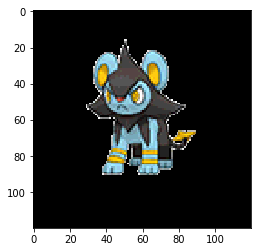

In [632]:
img = cv2.imread('/kaggle/input/pokemon-images-and-types/images/images/luxio.png')
img_copy = np.copy(img)
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_copy)

**Convert to tensor**

In [633]:
# move channels dimen to the front
img_channel_first = np.moveaxis(img_copy, -1, 0)

In [617]:
# normalize, rescale entries to lie in [0,1]
norm_img = img_channel_first.astype("float32")/255

In [618]:
img_tensor = torch.from_numpy(norm_img).unsqueeze(0)

In [619]:
img_tensor.shape

torch.Size([1, 3, 120, 120])

**Design and visualise filters**

In [620]:
filter_vals = np.array([[1,1,1,1],
                        [1,1,1,1],
                        [-1,-1,-1,-1],
                        [-1,-1,-1,-1]
                       ])

Since I'm working with all 3 channels of the RGB input image. My 4 filters must also be 3D. I just repeat the same matrix for all dimensions of each filter.

In [634]:
filter_1 = np.expand_dims(filter_vals, axis=0)
filter_1 = np.repeat(filter_1,3,axis=0)
filter_1.shape

(3, 4, 4)

In [635]:
filter_2 = np.expand_dims(filter_vals.T, axis=0)
filter_2 = np.repeat(filter_2,3,axis=0)
filter_2.shape

(3, 4, 4)

In [636]:
filter_3 = np.expand_dims(-filter_vals, axis=0)
filter_3 = np.repeat(filter_3,3,axis=0)
filter_3.shape

(3, 4, 4)

In [637]:
filter_4 = np.expand_dims((-filter_vals).T, axis=0)
filter_4 = np.repeat(filter_4,3,axis=0)
filter_4.shape

(3, 4, 4)

In [638]:
filters_list = [filter_1, filter_2, filter_3, filter_4]
filters_tensor = np.array([filter_1, filter_2, filter_3, filter_4])

In [640]:
# Check shape
filters_tensor.shape

(4, 3, 4, 4)

**Define CNN**

In [642]:
class Net(nn.Module):
    
    def __init__(self, weight): # Change init to let me use my own weight
        super(Net, self).__init__()
        k_height, k_width = weight.shape[2:]
        self.conv = nn.Conv2d(3, 4, kernel_size = (k_height,k_width), bias=False)
        self.conv.weight = nn.Parameter(weight, requires_grad=False)
    
    def forward(self, x):
        conv_x = self.conv(x)
        activated = F.relu(conv_x)
        
        return conv_x, activated
# convert filters from numpy to torch
# also add a dimension between the number of stacks and the kernels
weights = torch.from_numpy(filters_tensor).type(torch.FloatTensor)   
model = Net(weights)
print(model)

Net(
  (conv): Conv2d(3, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [643]:
conv_x, activated = model(img_tensor)
activated.shape

torch.Size([1, 4, 117, 117])

** Visualise output from layers **

In [644]:
# function to visualise a layer
def vis_layer(layer):
    fig = plt.figure(figsize=(10,20))
    for i in range(len(layer[0])):
        ax = fig.add_subplot(1,4,i+1)
        img = layer[0,i].data.numpy()
        ax.imshow(layer[0,i].data.numpy(), cmap='gray')

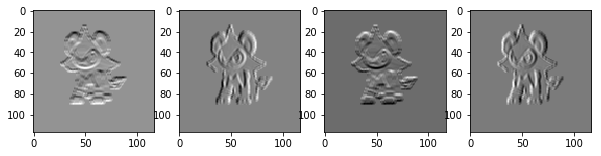

In [645]:
vis_layer(conv_x)

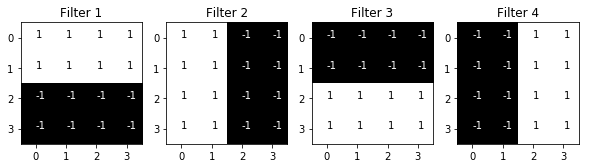

In [646]:
# visualise all my filters
fig = plt.figure(figsize=(10,5)) # blank figure to plot on
for i in range(len(filters)):
    ax = fig.add_subplot(1,4, i+1)
    ax.imshow(filters[i], cmap='gray')
    ax.set_title("Filter {}".format(i+1))
    for x in range(filters[i].shape[0]):
        for y in range(filters[i].shape[1]):
            color = "black"
            if filters[i][y,x] < 0:
                color = "white"
            ax.annotate(s=filters[i][y,x], xy=(x,y), color = color)


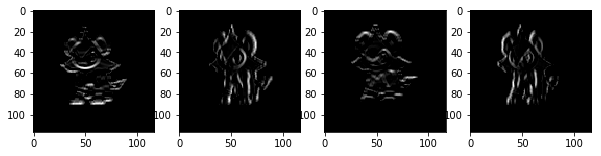

In [614]:
vis_layer(activated)